![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---



# Task 3 - Artificial Neural Network


In this assignment you will practice putting together a simple image classification pipeline, based on the Two-layer Neural Network classifier. The goals of this assignment are as follows:

    * understand the basic Image Classification pipeline using Multi-layered Neural Network
    * understand the train/val/test splits and the use of validation data for hyperparameter tuning.
    * develop proficiency in writing efficient vectorized code with numpy

    * implement and apply various classic activation functions
    * implement and apply mini-batch gradient descent
    * implement and apply regularization
    * implement and apply hyperparameter finetuning strategy

    * understand the differences and tradeoffs between these classifiers
    * the use of feature extraction to boost neural net performance

---
---


# [Part 0] Import Libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=7)

Write down your Name and Student ID

In [2]:
## --- start your code here ----

NIM = 1301170073
Nama = "Pratama Yoga Santosa"

## --- end your code here ----

# [Part 1] Binary Single Layer Perceptron

## 1 - Load Dataset

For this exercise, we will use binary class data to recognize `cats` and `not cats`. 
The images are $64\times64$ in dimension.


---
### a. Load Cat Dataset
first, load the dataset


In [3]:
import h5py    
    
def load_dataset():
    !wget 'https://raw.githubusercontent.com/CNN-ADF/Task2020/master/resources/catvnoncat.h5'
    dataset = h5py.File('catvnoncat.h5', "r")

    train_set_x_orig  = np.array(dataset["X_train"][:]) # your train set features
    train_set_y_orig  = np.array(dataset["y_train"][:]) # your train set labels
    val_set_x_orig    = np.array(dataset["X_val"][:]) # your val set features
    val_set_y_orig    = np.array(dataset["y_val"][:]) # your val set labels
    classes           = np.array(dataset["classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, val_set_x_orig, val_set_y_orig, classes

In [10]:
X_train_ori, y_train, X_val_ori, y_val, classes = load_dataset()

--2020-09-27 04:30:25--  https://raw.githubusercontent.com/CNN-ADF/Task2020/master/resources/catvnoncat.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3188774 (3.0M) [application/octet-stream]
Saving to: ‘catvnoncat.h5.1’

catvnoncat.h5.1     100%[===================>]   3.04M  11.5MB/s    in 0.3s    

2020-09-27 04:30:26 (11.5 MB/s) - ‘catvnoncat.h5.1’ saved [3188774/3188774]



In [11]:
print(X_train_ori.shape)
print(y_train.shape)
print(X_val_ori.shape)
print(y_val.shape)

(209, 64, 64, 3)
(209, 1)
(50, 64, 64, 3)
(50, 1)


**EXPECTED OUTPUT**: 
<pre>
(209, 64, 64, 3)
(209, 1)
(50, 64, 64, 3)
(50, 1)

View some data

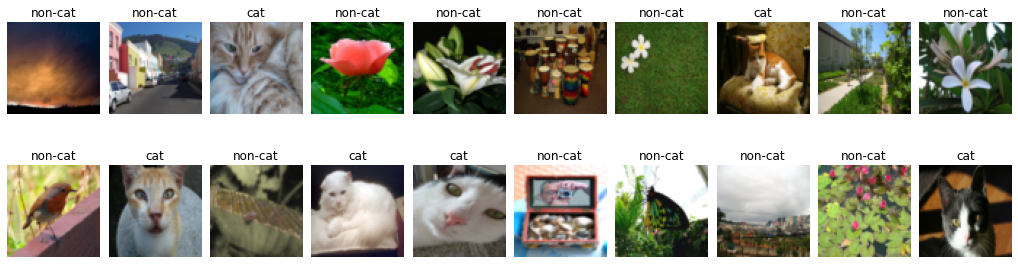

In [12]:
fig, ax = plt.subplots(2,10,figsize=(18,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train_ori[i+j*10])
        ax[j,i].set_title(classes[y_train[i+j*10,0]].decode("utf-8") )
        ax[j,i].axis('off')
plt.show()

---
### b. Reshape and Normalize

#### <font color='red'>**EXERCISE**: </font>
    * Reshape `X_train_ori` and `X_val_ori` into 1-dimensional matrix, 
    * Store it as `X_train` and `X_val`
    * the `X_train_ori` and `X_val_ori` shape should still be 
      (209, 64, 64, 3) and (50, 64, 64, 3)

<br>

*Hint: use `np.reshape()`*

In [15]:
X_train = X_train_ori.reshape(X_train_ori.shape[0], X_train_ori.shape[1]*X_train_ori.shape[2]*X_train_ori.shape[3])
X_val   = X_val_ori.reshape(X_val_ori.shape[0], X_val_ori.shape[1]*X_val_ori.shape[2]*X_val_ori.shape[3])

In [16]:
print('before')
print(X_train_ori.shape)
print(X_val_ori.shape)

print('\nafter')
print(X_train.shape)
print(X_val.shape)

before
(209, 64, 64, 3)
(50, 64, 64, 3)

after
(209, 12288)
(50, 12288)


**EXPECTED OUTPUT**: 
<pre>
before
(209, 64, 64, 3)
(50, 64, 64, 3)

after
(209, 12288)
(50, 12288)


<br>

#### <font color='red'>**EXERCISE**: </font>
    * Since for this dataset using sigmoid and regression is enough, 
    * standarize the dataset into a `range of 0-1` by dividing it with `255`

In [17]:
print('before',X_train[0,:6])

before [17 31 56 22 33 59]


**EXPECTED OUTPUT**: 
<pre>
    before [17 31 56 22 33 59]

In [19]:
# divide with `255`
X_train = X_train / 255
X_val   = X_val / 255

In [20]:
print('after',X_train[0,:6])

after [0.0666667 0.1215686 0.2196078 0.0862745 0.1294118 0.2313725]


**EXPECTED OUTPUT**: 
<pre>
after [0.0666667 0.1215686 0.2196078 0.0862745 0.1294118 0.2313725]

---
## 2 - Basic Neurons

<center>
<img src="https://i.ibb.co/y4Zz3Gy/neuron.png" width="50%" >
</center>

Standard neuron is basically the same as previous linear function. 


---
### a. Forward and Backward Affine Function



#### <font color='red'>**EXERCISE**: </font>
    * Implement Affine forward function:

$$
\begin{align}
f(x, W, b) = x.W + b
\end{align}
$$


In [21]:
def affine_forward(x, W, b):  
  
    v = np.dot(x, W) + b            # x dot W + b   
    
    return v



<br>

#### <font color='red'>**EXERCISE**: </font>
    * Implement affine backward function:


$$
\begin{align*}
\partial W & = x^T.\partial out \\
\partial b & = \sum \partial out \\
\partial x & = \partial out.W^T \\
\end{align*}
$$

In [22]:
def affine_backward(dout, x, W, b):
  
    dW = np.dot(x.T,dout)           # x.T dot dout
    db = np.sum(dout, axis=0, keepdims=True)           # sum dout, axis=0, keepdims=True
    dx = dout.dot(W.T)           # dout dot W.T
    
    return dW, db, dx

---
### b. Forward and Backward Sigmoid Function


Also implement the activation function

#### <font color='red'>**EXERCISE**: </font>
    * Implement Sigmoid forward function:

$$
\begin{align}
f(x) = \sigma(x) = \frac{1}{1+e^{-v}}
\end{align}
$$

<center>
<img src="https://i.ibb.co/QjF8sDx/sigmoid.png" width="20%" >
</center>


In [25]:
def sigmoid_forward(x):  
  
    out = 1 / (1 + np.exp(-x))

    return out

Check your implementation

In [33]:
x  = np.array([-2, -1, 0, 1, 2, 3])
ds = sigmoid_forward(x)

print(ds)

[0.1192029 0.2689414 0.5       0.7310586 0.8807971 0.9525741]


**EXPECTED OUTPUT**:

<pre> [0.1192029 0.2689414 0.5       0.7310586 0.8807971 0.9525741]


---
<br>

#### <font color='red'>**EXERCISE**: </font>
    * Implement Sigmoid backward function
$$
\begin{align*}
\sigma'(x) = \sigma(x) \ (1 - \sigma(x))\\\\
\partial out = \partial out . \sigma'(x)
\end{align*}
$$
<br>

In [49]:
def sigmoid_backward(dout, ds):
    """
    Argument:
        ds: sigmoid forward result
        dout: gradient error
    """
    
    # calculate the local gradient of sigmoid
    ds_prime = ds*(1-ds)
    
    # calculate the gradient propagation
    dout = dout*ds_prime
    return dout

Check your implementation

In [50]:
np.random.seed(10)
dout = np.random.random((6,)) 
dout = sigmoid_backward(dout, ds)
print(dout)

[0.0809837 0.0040801 0.1584121 0.1472238 0.05234   0.0101556]


**EXPECTED OUTPUT**:

<pre> [0.0809837 0.0040801 0.1584121 0.1472238 0.05234   0.0101556]



---
### c. Forward and Backward Tanh Function

We haven't discussed aboout activation function yet in class, but the implementation of these functions are quite easy, so you should be able to handle it

#### <font color='red'>**EXERCISE**: </font>
    * Implement `Tanh` forward function

**hint: use `np.tanh(x)`*

$$
\begin{align}
f(x) = tanh(x)
\end{align}
$$

<center>
<img src="https://i.ibb.co/JQCczk5/tanh.png" width="20%" >
</center>


In [51]:
def tanh_forward(x):  
  
    out = np.tanh(x)
    
    return out

Check your implementation

In [52]:
x  = np.array([-2, -1, 0, 1, 2, 3])
dt = tanh_forward(x)

print(dt)

[-0.9640276 -0.7615942  0.         0.7615942  0.9640276  0.9950548]


**EXPECTED OUTPUT**:

<pre> [ -0.9640276 -0.7615942  0.         0.7615942  0.9640276  0.9950548]



---
<br>

#### <font color='red'>**EXERCISE**: </font>
    * Implement Tanh backward function
$$
\begin{align*}
f'(x) = 1-f(v)^2\\
\\
\partial out = \partial out . f'(x)
\end{align*}
$$
<br>

In [53]:
def tanh_backward(dout, dt):
    """
    Argument:
        dt: tanh forward result
        dout: gradient error
    """
    
    # calculate the local gradient of tanh
    dt_prime = 1 - (dt**2)         # 1- dt^2
    
    # calculate the gradient propagation
    dout = dout*dt_prime
    
    return dout

Check your implementation

In [54]:
np.random.seed(10)
dout = np.random.random((6,)) 
dout = tanh_backward(dout, dt)
print(dout)

[0.0544944 0.0087153 0.6336482 0.3144784 0.0352199 0.0022179]


**EXPECTED OUTPUT**:

<pre> [0.0544944 0.0087153 0.6336482 0.3144784 0.0352199 0.0022179]


---
### d. Forward and Backward ReLU Function

Next we implement ReLU activation function

We haven't discussed aboout activation function yet in class, but the implementation of these functions are quite easy, so you should be able to handle it


#### <font color='red'>**EXERCISE:** </font>
* Implement ReLU forward function:


$$
\begin{align}
f(x) = 
\begin{cases}
0, & \text{for } x<0\\
x, & \text{for } x\geq0
\end{cases}
\end{align}
$$

<center>
<img src="https://i.ibb.co/rmXqJyh/relu.png" width="20%" >
</center>

**hint: use `np.maximum()`*

In [57]:
def relu_forward(x): 
  
    out = np.maximum(0,x)
    
    return out

Check your implementation

In [58]:
x  = np.array([-2, -1, 0, 1, 2, 3])
dr = relu_forward(x) 

print(dr)

[0 0 0 1 2 3]


**EXPECTED OUTPUT**:

<pre> [0, 0, 0, 1, 2, 3]


---

<br>

#### <font color='red'>**EXERCISE:** </font>
* Implement ReLU backward function
$$
\begin{align*}
f'(v) = 
\begin{cases}
0, & \text{for } x<0\\
1, & \text{for } x\geq0
\end{cases}\\
\\
\partial out = \partial out . f'(x)
\end{align*}
$$

**hint: use `np.where(condition, if true, if false)`*

In [59]:
def relu_backward(dout, x):
    """
    Argument:
        x: relu input
        dout: gradient error
    """
    
    # calculate the local gradient of relu
    dr_prime = np.where(x>=1, 1, 0)
    
    # calculate the gradient propagation
    dout = dout*dr_prime
    
    return dout

Check your implementation

In [60]:
np.random.seed(10)
dout = np.random.random((6,)) 
dout = relu_backward(dout, x)
print(dout)

[0.        0.        0.        0.7488039 0.498507  0.2247966]


**EXPECTED OUTPUT**:

<pre> [0.        0.        0.        0.7488039 0.498507  0.2247966]



---
## 3 - One-Layer Sigmoid

We'll train a Single Layer Perceptron with Sigmoid for binary Classification using Full batch **Gradient Descent**


<center>
<img src="https://i.ibb.co/4mQBjd8/Single-Layer-Perceptron.png" width="25%" >
</center>



### a. Training Function

The network architecture should be: <br>
<pre><font color="blue"><b>Input - FC layer - Sigmoid</b></font></pre>



#### <font color='red'>**EXERCISE:** </font>
Implement Training Function

    * call affine forward function
    * call sigmoid forward function
    * apply L2 loss regression (MSE)
    * call affine backward function
    * implement weight update

<br>

**Note** that we do not calculate `sigmoid backward` as in Single Layer Perceptron `sigmoid` is used directly as output activation

In [61]:
def train_one_layer(X, y, W=None, b=None, lr=0.005, epochs=100, verbose=True):
    
    
    num_train, dim = X.shape
    
    num_classes = 1
    
    # initialize weights if not provided
    if W is None:
        W = 0.02*np.random.rand(dim, num_classes)
    if b is None:
        b = np.zeros((1, num_classes))

    # Run stochastic gradient descent to optimize W
    loss_history = []
                     
    for ep in range(epochs):
        

        # calculate 1st layer score by calling affine forward function using X, W, and b
        layer1 = affine_forward(X, W, b)
        
        # calculate 1st activation score by calling sigmoid forward function using layer1 score
        act1 = sigmoid_forward(layer1)
        
        # calculate error by subtracting act1 with y
        error = act1 - y
        
        # calculate L2 Loss (MSE) by averaging the squared error
        loss = np.mean(np.square(error))
        
        # divide error by num_train
        error = error/num_train
    
        # calculate layer 1 weights gradient by calling affine backward function using error, X, W, and b
        dW, db, _ = affine_backward(error, X, W, b)

        
        # perform parameter update by subtracting each W and b with a fraction of dW and db
        # according to the learning rate
        W -= lr*dW                       # W-lr*dW
        b -= lr*db                       # b-lr*db

        
        if verbose and ep % 100 == 0:
            print ('epoch',ep,'/',epochs, ': loss =', loss)
            
            # append the loss history
            loss_history.append(loss)

    print('Training done')
    return W, b, loss_history

### b. Train the Binary Classifier

Try the training Function using the initial parameter

In [62]:
W, b, loss = train_one_layer(X_train, y_train, epochs=1000, lr=0.005)

epoch 0 / 1000 : loss = 0.6554838533139654
epoch 100 / 1000 : loss = 0.2188320355466711
epoch 200 / 1000 : loss = 0.1612961378750308
epoch 300 / 1000 : loss = 0.11340964774329293
epoch 400 / 1000 : loss = 0.09326197928096298
epoch 500 / 1000 : loss = 0.08250527006724964
epoch 600 / 1000 : loss = 0.07380234349511444
epoch 700 / 1000 : loss = 0.06657927073121862
epoch 800 / 1000 : loss = 0.06047415680046653
epoch 900 / 1000 : loss = 0.05523946194103321
Training done


**EXPECTED OUTPUT**:

<pre>The loss should starts around 0.6 and ends around 0.05

Visualize the loss

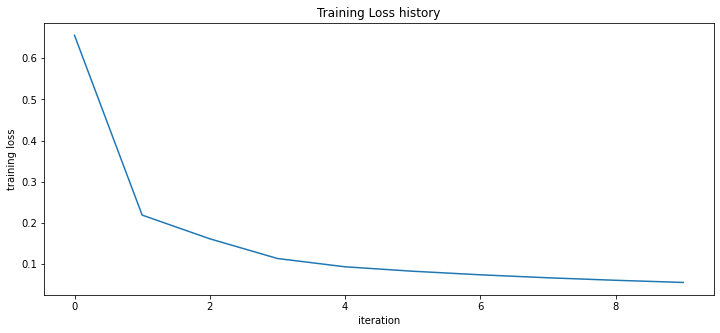

In [63]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(loss)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


### c. Predict Function

The network architecture should be: <br>
<pre><font color="blue"><b>Input - FC layer - Sigmoid</b></font></pre>



#### <font color='red'>**EXERCISE:** </font>
Implement Predict Function

    * call forward function

In [64]:
def predict_one_layer(X, W, b):    
    y_pred = np.zeros(X.shape[1])
    
    # calculate 1st layer score by calling affine forward function using X, W, and b
    layer1 = affine_forward(X, W, b)

    # calculate 1st activation score by calling sigmoid forward function using layer1 score
    act1 = sigmoid_forward(layer1)
    
    # since it's a binary class, round the score to get the class
    y_pred = np.round(act1)
    
    return y_pred

### d. Training Accuracy
Calculate the Training Accuracy

In [65]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_one_layer(X_train, W, b)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label    =',y_train[:15].ravel())
print('Predicted label   =',y_pred[:15].astype('int').ravel())

Training Accuracy = 96.65071770334929 %
Training label    = [0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]
Predicted label   = [0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]


**EXPECTED OUTPUT**:

<pre>You should get about <b>~95%</b> accuracy on training set using the initial run</pre>

Calculate the Validation Accuracy

In [66]:
y_pred = predict_one_layer(X_val, W, b)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label    =',y_val[:15].ravel())
print('Predicted label     =',y_pred[:15].astype('int').ravel())

Validation Accuracy = 76.0 %
Validation label    = [1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
Predicted label     = [1 1 1 1 1 0 0 1 1 1 0 1 1 1 0]


**EXPECTED OUTPUT**:

<pre>You should also get about <b>~74%</b> accuracy on validation set</pre>

<br>

You can retrain further the weights by adding the pre-trained W and b to the arguments when calling training function



In [ ]:
# loss, W, b = train_one_layer(X_train, y_train, W=W, b=b, num_iters=1000, learning_rate=0.005)

---
---
# [Part 2] Multi-Layered Perceptron

Now, let's build some multi-layered Neural Networks and train it using CIFAR-10 dataset

---
## 1 - Load CIFAR-10 Dataset

CIFAR-10 dataset is a image classification dataset, consisting of 10 classes. 

The images are $32\times32$ color image with 50,000 data train and 10,000 data test

---
### a. Import Data CIFAR-10

In [67]:
import tensorflow as tf

(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = tf.keras.datasets.cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('X_train.shape =',X_train_ori.shape)
print('y_train.shape =',y_train_ori.shape)
print('X_test.shape  =',X_test_ori.shape)
print('y_test.shape  =',y_test_ori.shape)


170500096/170498071 [==============================] - 2s 0us/step
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape  = (10000, 32, 32, 3)
y_test.shape  = (10000, 1)


---
### b. Visualizing Data
Show the first 20 images from `X_train`

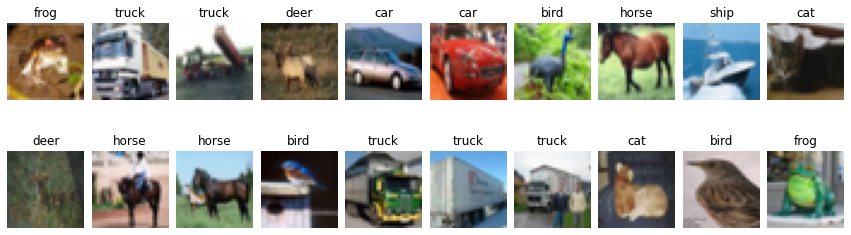

In [68]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train_ori[i+j*10])
        ax[j,i].set_title(classes[y_train_ori[i+j*10,0]])
        ax[j,i].axis('off')
plt.show()

---
### c. Split Training Data

Get the last 10000 data from Training Set as Validation Set

In [69]:
X_val   = X_train_ori[-10000:,:]
y_val   = y_train_ori[-10000:]

X_train = X_train_ori[:-10000, :]
y_train = y_train_ori[:-10000]

X_test  = X_test_ori
y_test  = y_test_ori

print('X_val.shape   =',X_val.shape)
print('y_val.shape   =',y_val.shape)
print('X_train.shape =',X_train.shape)
print('y_train.shape =',y_train.shape)

X_val.shape   = (10000, 32, 32, 3)
y_val.shape   = (10000, 1)
X_train.shape = (40000, 32, 32, 3)
y_train.shape = (40000, 1)


---
### d. Normalizing Data
Normalize `X_train`, `X_val` and `X_test` by *zero-centering* them:

In [70]:
X_train = X_train.astype('float32')
X_val   = X_val.astype('float32')
X_test  = X_test.astype('float32')

mean_image = np.mean(X_train, axis = 0)
X_train   -= mean_image
X_val     -= mean_image
X_test    -= mean_image

print('np.mean(X_train) =',np.mean(X_train))
print('np.mean(X_val)   =',np.mean(X_val))
print('np.mean(X_test)  =',np.mean(X_test))


np.mean(X_train) = -9.2315673e-07
np.mean(X_val)   = 0.14794703
np.mean(X_test)  = 0.8511902


---
### e. Reshape Data
Reshape each data in `X_train`, `X_val` and `X_test` into 1-dimensional matrix


In [71]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]) )
X_val   = X_val.reshape(  (X_val.shape[0],   X_val.shape[1]   * X_val.shape[2]   * X_val.shape[3]) )
X_test  = X_test.reshape( (X_test.shape[0],  X_test.shape[1]  * X_test.shape[2]  * X_test.shape[3]) )

print('X_train.shape =',X_train.shape)
print('X_val.shape   =',X_val.shape)
print('X_test.shape  =',X_test.shape)

X_train.shape = (40000, 3072)
X_val.shape   = (10000, 3072)
X_test.shape  = (10000, 3072)


 Reshape `y_train`, `y_val` and `y_test` into a vector 


In [72]:
y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

print('y_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

y_train.shape = (40000,)
y_val.shape   = (10000,)
y_test.shape  = (10000,)


---
## 2 - Softmax Function 


### a. Softmax Score

The implementation is the same as previous Task, so in here we already provide you with the implementation


In [73]:
def softmax(x):  
    
    # shift x by subtracting with its maximum value . Use np.max(...)
    x -= np.max(x)
    
    # Apply exp() element-wise to x. Use np.exp(...).    
    x_exp = np.exp(x)
    
    # Create a vector X_sum that sums each row of X_exp. Use np.sum(..., axis = 1, keepdims = True).
    x_sum = np.sum(x_exp, axis = 1, keepdims = True)  
    
    # Compute softmax(x) score by dividing X_exp by X_sum. It should automatically use numpy broadcasting.
    score = x_exp / x_sum
    
    return score

### b. Softmax Loss

Implement a softmax loss function using numpy. The implementation is the same as previous Task, so in here we already provide you with the implementation


In [74]:
def softmax_loss(score, y):
   
    num_examples = score.shape[0]
    
    #make a number list containing [1 2 3 ... n]
    number_list = range(num_examples)
    
    # calculate the correct log probability of score[number_list,y] by applycing -np.log(...)
    corect_logprobs = -np.log(score[number_list,y])
    
    # average the correct log probability, use np.sum then divide it by num_examples
    loss = np.sum(corect_logprobs)/num_examples
    
    
    # 3. COMPUTE THE GRADIENT ON SCORES
    dscores = score
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    
    return loss, dscores

---
## 3 - Two-Layered Sigmoid with Softmax


<center>
<img src="https://i.ibb.co/0KVzGBJ/2-Layer-Perceptron.png" width="35%" >
</center>


---

### a. Training Function

The network architecture should be: 
<pre><font color="blue"><b>Input - FC layer - Sigmoid - FC Layer - Softmax</b></font></pre>



#### <font color='red'>**EXERCISE:** </font>

Implement Training Function

    * call affine forward function
    * call sigmoid forward function
    * call affine forward function
    
    * call softmax function
    * call softmax_loss function
    
    * call affine backward function
    * call sigmoid backward function
    * call affine backward function
    
    * implement weight update

In [75]:
def train_two_layer_sigmoid(X, y, hidden_size, W=None, b=None, 
                            lr=1e-4, lr_decay=0.9, reg=0.25, 
                            epochs=100, batch_size=200, verbose=True):
    
    num_train, dim = X.shape
    
    # check if data train is divisible by batch size
    assert num_train % batch_size==0, "data train "+str(num_train)+" is not divisible by batch size"+str(batch_size)
    
    # total iteration per epoch
    num_iter = num_train // batch_size
    
    #start iteration counts
    it = 0
    
    num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
    
    # initialize weights if not provided
    if W is None:
        W0 = 1e-4 * np.random.randn(dim, hidden_size)
        W1 = 1e-4 * np.random.randn(hidden_size, num_classes)
        W = [W0, W1]
    if b is None:
        b0 = np.zeros((1,hidden_size))
        b1 = np.zeros((1,num_classes))
        b = [b0, b1]

    # Run stochastic gradient descent to optimize W
    loss_history = []
                     
    for ep in range(epochs):
        # Shuffle data train index
        train_rows = np.arange(num_train)
        np.random.shuffle(train_rows)
        
        # split index into mini batches
        id_batch = np.split(train_rows, num_iter)
        
        for batch in id_batch:
          
            # get mini batch data and label
            X_batch = X[batch]
            y_batch = y[batch]


            # calculate 1st layer score by calling affine forward function using X_batch, W[0], and b[0]
            layer1 = affine_forward(X_batch, W[0], b[0])


            # calculate 1st activation score by calling sigmoid forward function using layer1 score
            act1 = sigmoid_forward(layer1)


            # calculate 2nd layer score by calling affine forward function using act1, W[1], and b[1]
            layer2 = affine_forward(act1, W[1], b[1])


            # calculate softmax score by calling softmax function using layer2 score
            softmax_score = softmax(layer2)


            # evaluate loss and gradient by calling softmax_loss function using softmax_score and y_batch
            loss, dout = softmax_loss(softmax_score, y_batch)


            # add regularization to the loss
            loss+= reg * (np.sum(W[0] * W[0]) + np.sum(W[1] * W[1]))

            # append the loss history
            loss_history.append(loss)

            # calculate layer 2 weights gradient by calling affine backward function using dout, act1, W[1], and b[1]
            dW1, db1, dact1 = affine_backward(dout, act1, W[1], b[1])


            # calculate sigmoid gradient by calling sigmoid backward function using dact1 and act1 score
            dlayer1 = sigmoid_backward(dact1, act1)


            # calculate layer 1 weights gradient by calling affine backward function using dlayer1, X_batch, W[0], and b[0]
            dW0, db0, _ = affine_backward(dlayer1, X_batch, W[0], b[0])


            # perform regulatization gradient
            dW1 += 2 * reg * W[1]
            dW0 += 2 * reg * W[0]

            # perform parameter update by subtracting W and b with a fraction of dW and db
            # according to the learning rate            
            W[0] -= lr * dW0             # W0 - lr * dW0
            b[0] -= lr * db0            # b0 - lr * db0
            W[1] -= lr * dW1             # W1 - lr * dW1
            b[1] -= lr * db1            # b1 - lr * db1
        
            # iteration count
            it +=1

            if verbose and it % 100 == 0:
                print ('iteration',it,'(epoch', ep,'/',epochs, '): loss =', loss)
                
                
        # At the end of one epoch
        # Decay learning rate
        lr *= lr_decay
            
    print('Training Done')
    return W, b, loss_history

---
### b. Train the Softmax Classifier

Try the training Function using the initial parameter

In [76]:
W_sigm, b_sigm, loss = train_two_layer_sigmoid(X_train, y_train, hidden_size=50, epochs=15)

iteration 100 (epoch 0 / 15 ): loss = 2.302907201210755
iteration 200 (epoch 0 / 15 ): loss = 2.3028030747234793
iteration 300 (epoch 1 / 15 ): loss = 2.3026356519771385
iteration 400 (epoch 1 / 15 ): loss = 2.30220285949726
iteration 500 (epoch 2 / 15 ): loss = 2.301300006511869
iteration 600 (epoch 2 / 15 ): loss = 2.3003153028093233
iteration 700 (epoch 3 / 15 ): loss = 2.3001928895690233
iteration 800 (epoch 3 / 15 ): loss = 2.2994218914551485
iteration 900 (epoch 4 / 15 ): loss = 2.297716918198049
iteration 1000 (epoch 4 / 15 ): loss = 2.2973833889639126
iteration 1100 (epoch 5 / 15 ): loss = 2.2964488288094995
iteration 1200 (epoch 5 / 15 ): loss = 2.2960365242875596
iteration 1300 (epoch 6 / 15 ): loss = 2.2927257413842277
iteration 1400 (epoch 6 / 15 ): loss = 2.2940385151149463
iteration 1500 (epoch 7 / 15 ): loss = 2.290688670625184
iteration 1600 (epoch 7 / 15 ): loss = 2.291688255468618
iteration 1700 (epoch 8 / 15 ): loss = 2.2901459523729693
iteration 1800 (epoch 8 / 15 )

**EXPECTED OUTPUT**:

<pre>The loss should starts around 2.3 and ends around 2.27</pre>

Visualize the loss

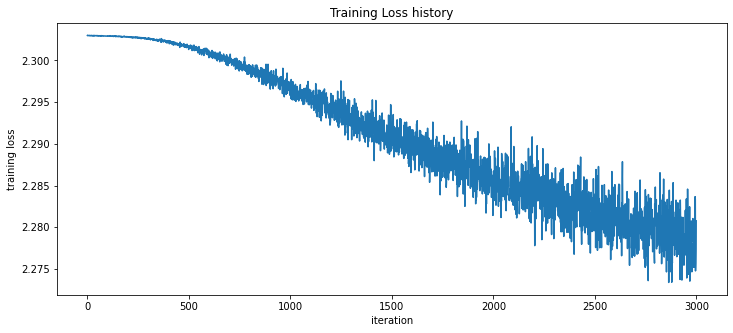

In [77]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(loss)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

---
### c. Predict Function
Implement Predict function

The network architecture should be: 
<pre><font color="blue"><b>Input - FC layer - Sigmoid - FC Layer - argmax</b></font></pre>



#### <font color='red'>**EXERCISE:** </font> 

Implement Predict Function

    * call affine forward function
    * call sigmoid forward function
    * call affine forward function
    * call argmax to get max score id


In [78]:
def predict_two_layer_sigmoid(X, W, b):    
    y_pred = np.zeros(X.shape[1])

    
    # calculate 1st layer score by calling affine forward function using X_batch, W[0], and b[0]
    layer1 = affine_forward(X, W[0], b[0])


    # calculate 1st activation score by calling sigmoid forward function using layer1 score
    act1 = sigmoid_forward(layer1)


    # calculate 2nd layer score by calling affine forward function using act1, W[1], and b[1]
    layer2 = affine_forward(act1, W[1], b[1])

    
    # take the maximum prediction from layer 2 and use that column to get the class   
    # use np.argmax with axis=-1 
    y_pred = np.argmax(layer2, axis=-1 )

    
    return y_pred

### d. Training Accuracy
Calculate the Training Accuracy

In [79]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_two_layer_sigmoid(X_train, W_sigm, b_sigm)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label  =',y_train[:15])
print('Predicted label =',y_pred[:15])

Training Accuracy = 17.6125 %
Training label  = [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9]
Predicted label = [6 8 8 6 8 6 6 6 8 6 6 8 8 6 6]


**EXPECTED OUTPUT**:

<pre>You should get about <b>~17%</b> accuracy on training set using the initial run

In [80]:
y_pred = predict_two_layer_sigmoid(X_val, W_sigm, b_sigm)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label =',y_val[:15])
print('Predicted label  =',y_pred[:15])

Validation Accuracy = 17.32 %
Validation label = [1 8 5 1 5 7 4 3 8 2 7 2 0 1 5]
Predicted label  = [8 8 6 8 6 6 6 6 8 6 6 6 8 8 6]


**EXPECTED OUTPUT**:

<pre>You should also get about <b>~17%</b> accuracy on validation set</pre>

<br>

You can retrain further the weights by adding the pre-trained `W` and `b` to the arguments when calling training function


In [ ]:
# W_sigm, b_sigm, loss = train_two_layer_sigmoid(X_train, y_train, W=W_sigm, b=b_sigm, hidden_size=50, epochs=3000)

---
## 4 - Two-Layer ReLU with Softmax

Now we implement Two-Layer Neural Network, but this time we're using ReLU activation function

By the end of this part you should see that ReLU converge much faster compared to Sigmoid


### a. Predict Function

This time, we implement the predict function first, because we are going to use `predict` function inside the `training` function to track the `validation` accuracy 

The network architecture should be: 
<pre><font color="blue"><b>Input - FC layer - ReLU - FC Layer - argmax


#### <font color='red'>**EXERCISE:**</font> 
Implement Predict Function

    * call affine forward function
    * call relu forward function
    * call affine forward function
    * call argmax to get max score id

In [81]:
def predict_two_layer_relu(X, W, b):    
    y_pred = np.zeros(X.shape[1])

    
    # calculate 1st layer score by calling affine forward function using X_batch, W[0], and b[0]
    layer1 = affine_forward(X, W[0], b[0])

    # calculate 1st activation score by calling relu forward function using layer1 score
    act1 = relu_forward(layer1)

    # calculate 2nd layer score by calling affine forward function using act1, W[1], and b[1]
    layer2 = affine_forward(act1, W[1], b[1])
    
    # take the maximum prediction from layer 2 and use that column to get the class    
    # use np.argmax with axis=-1 
    y_pred = np.argmax(layer2, axis=-1) 
    
    return y_pred

### b. Training Function

The network architecture should be: 
<pre><font color="blue"><b>Input - FC layer - ReLU - FC Layer - Softmax




#### <font color='red'>**EXERCISE:**</font> 

Implement Training Function

    * implement mini batch gradient descent
    
    * call affine forward function
    * call relu forward function
    * call affine forward function
    
    * call softmax function
    * call softmax_loss function
    
    * call affine backward function
    * call relu backward function
    * call affine backward function
    
    * implement weight update
    * add weights regularization
    * calculate the training and validation accuracy
    * decay learning rate
    

In [82]:
def train_two_layer_relu(X, y, X_val, y_val, hidden_size, 
                         W=None, b=None, lr=1e-4, lr_decay=0.9, 
                         reg=0.25, epochs=100, batch_size=200, verbose=True):
  
    num_train, dim = X.shape
    
    # check if data train is divisible by batch size
    assert num_train % batch_size==0, "data train "+str(num_train)+" is not divisible by batch size"+str(batch_size)
    
    # total iteration per epoch
    num_iter = num_train // batch_size
    
    #start iteration counts
    it = 0
    
    num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
    
    # initialize weights if not provided
    if W is None:
        W0 = 1e-4 * np.random.randn(dim, hidden_size)
        W1 = 1e-4 * np.random.randn(hidden_size, num_classes)
        W = [W0, W1]
    if b is None:
        b0 = np.zeros((1,hidden_size))
        b1 = np.zeros((1,num_classes))
        b = [b0, b1]

    # Run stochastic gradient descent to optimize W
    loss_history = []
    train_acc_history = []
    val_acc_history = []
                     
    for ep in range(epochs):
        # Shuffle data train index
        # see sigmoid train function
        train_rows = np.arange(num_train)
        np.random.shuffle(train_rows)
        
        # split index into mini batches
        # see sigmoid train function
        id_batch = np.split(train_rows, num_iter)
        
        for batch in id_batch:
      
            # get mini batch data and label
            X_batch = X[batch]
            y_batch = y[batch]

            # calculate 1st layer score by calling affine forward function using X_batch, W[0], and b[0]
            layer1 = affine_forward(X_batch, W[0], b[0])

            # calculate 1st activation score by calling relu forward function using layer1 score
            act1 = relu_forward(layer1)

            # calculate 2nd layer score by calling affine forward function using act1, W[1], and b[1]
            layer2 = affine_forward(act1, W[1], b[1])

            # calculate softmax score by calling softmax function using layer2 score
            softmax_score = softmax(layer2)

            # evaluate loss and gradient by calling softmax_loss function using softmax_score and y_batch
            loss, dout = softmax_loss(softmax_score, y_batch)

            # add regularization to the loss:
            #    for each weights, calculate the sum square, multiply by regularization strength
            #    then add it to the loss      
            # see sigmoid train function
            loss+= reg * (np.sum(W[0] * W[0]) + np.sum(W[1] * W[1]))

            # append the loss history
            loss_history.append(loss)

            # calculate layer 2 weights gradient by calling affine backward function using dout, act1, W[1], and b[1]
            dW1, db1, dact1 = affine_backward(dout, act1, W[1], b[1])

            # calculate sigmoid gradient by calling relu backward function using dact1 and act1 score
            dlayer1 = relu_backward(dact1, act1)

            # calculate layer 1 weights gradient by calling affine backward function using dlayer1, X_batch, W[0], and b[0]
            dW0, db0, _ = affine_backward(dlayer1, X_batch, W[0], b[0])


            # perform regulatization gradient
            # for each dWi, add with twice the weight multiplied by regularization strength
            # see sigmoid train function
            dW1 += 2 * reg * W[1]
            dW0 += 2 * reg * W[0]


            # perform parameter update by subtracting W and b with a fraction of dW and db
            # according to the learning rate
            W[0] -= lr * dW0             
            b[0] -= lr * db0           
            W[1] -= lr * dW1            
            b[1] -= lr * db1
  
            # iteration count
            it +=1

      
            if verbose and it % 100 == 0:
                print ('iteration',it,'(epoch', ep,'/',epochs, '): loss =', loss)

            
        # At the end of one epoch
        # 1. Check accuracy
        #    calculate the training accuracy by calling predict_two_layer_relu function on X_batch
        #    and compare it tu y_batch. Then calculate the mean correct (accuracy in range 0-1)
        train_acc = (predict_two_layer_relu(X_batch, W, b) == y_batch).mean()
        train_acc_history.append(train_acc)

        # 2. Calculate the training accuracy by calling predict_two_layer_relu function on X_val
        #    and compare it tu y_val. Then calculate the mean correct (accuracy in range 0-1)
        val_acc = (predict_two_layer_relu(X_val, W, b) == y_val).mean()
        val_acc_history.append(val_acc)

        # 3. Decay learning rate
        #    multiply learning rate with decay
        #    see sigmoid train function
        lr *= lr_decay
  
    # compile all history
    history = [loss_history, train_acc_history, val_acc_history]
    
    if verbose:
        print('Training Done')
      
    return W, b, history

### c. Train the Softmax Classifier

Try the training Function using the initial parameter

In [83]:
W_relu, b_relu, history = train_two_layer_relu(X_train, y_train, 
                                               X_val, y_val, 
                                               hidden_size=50, 
                                               epochs=8)

iteration 100 (epoch 0 / 8 ): loss = 2.302813639406816
iteration 200 (epoch 0 / 8 ): loss = 2.3020052228701258
iteration 300 (epoch 1 / 8 ): loss = 2.294708377161222
iteration 400 (epoch 1 / 8 ): loss = 2.26009324875114
iteration 500 (epoch 2 / 8 ): loss = 2.2334098378531877
iteration 600 (epoch 2 / 8 ): loss = 2.137403011182794
iteration 700 (epoch 3 / 8 ): loss = 2.1494532344329293
iteration 800 (epoch 3 / 8 ): loss = 2.086769971759729
iteration 900 (epoch 4 / 8 ): loss = 2.0548509367768366
iteration 1000 (epoch 4 / 8 ): loss = 2.113330851678528
iteration 1100 (epoch 5 / 8 ): loss = 2.0410364231541864
iteration 1200 (epoch 5 / 8 ): loss = 2.084627193146931
iteration 1300 (epoch 6 / 8 ): loss = 1.9495709464111846
iteration 1400 (epoch 6 / 8 ): loss = 1.9750037816901058
iteration 1500 (epoch 7 / 8 ): loss = 1.9676424135495107
iteration 1600 (epoch 7 / 8 ): loss = 2.0762362259395917
Training Done


**EXPECTED OUTPUT**:

<pre>The loss should starts around 2.3 and ends around 1.8 with only 8 epochs</pre>

Visualize the loss

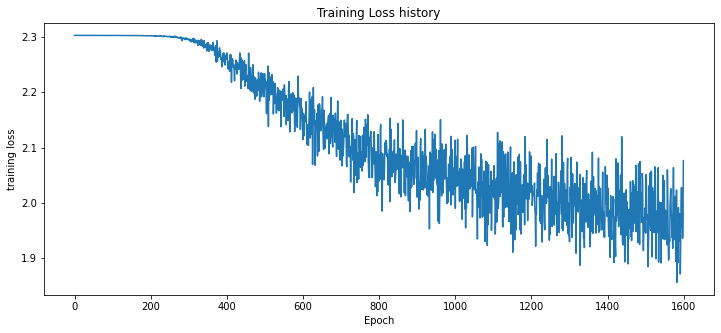

In [84]:
loss, train_acc, val_acc = history

plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


Visualize the training and validation accuracy

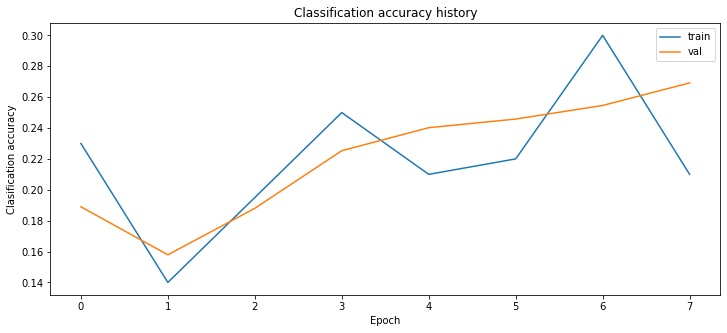

In [85]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

### d. Training Accuracy
Calculate the Training Accuracy

In [86]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_two_layer_relu(X_train, W_relu, b_relu)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label  =',y_train[:15])
print('Predicted label =',y_pred[:15])

Training Accuracy = 27.142500000000002 %
Training label  = [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9]
Predicted label = [6 8 9 6 9 6 6 4 8 9 6 0 8 6 9]


**EXPECTED OUTPUT**:

<pre>You should be able to get about <b>~32%</b> accuracy on training set using the initial run

In [87]:
y_pred = predict_two_layer_relu(X_val, W_relu, b_relu)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label =',y_val[:15])
print('Predicted label  =',y_pred[:15])

Validation Accuracy = 26.919999999999998 %
Validation label = [1 8 5 1 5 7 4 3 8 2 7 2 0 1 5]
Predicted label  = [9 9 6 9 6 5 6 6 8 6 0 0 0 8 9]


**EXPECTED OUTPUT**:

<pre>You should also be able to get about <b>~32%</b> accuracy on validation set</pre>

<br>

You can retrain further the weights by adding the pre-trained W and b to the arguments when calling training function

---


In [ ]:
# W_relu, b_relu, history = train_two_layer_relu(X_train, y_train, X_val, y_val, W=W_relu, b=b_relu, hidden_size=50, epochs=1000)

## 5 - First Layer Visualization


In [88]:
## run this to turn off the scrolling effect in jupyter notebook

from IPython.core.magics.display import Javascript
Javascript("""
  IPython.OutputArea.prototype._should_scroll = function(lines) {
      return false;
  }"""
)

## set return true to turn on the scrolling effect

<IPython.core.display.Javascript object>

In [89]:
!wget 'https://raw.githubusercontent.com/CNN-ADF/Task2020/master/resources/vis_utils.py'

--2020-09-27 05:14:45--  https://raw.githubusercontent.com/CNN-ADF/Task2020/master/resources/vis_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2163 (2.1K) [text/plain]
Saving to: ‘vis_utils.py’

vis_utils.py        100%[===================>]   2.11K  --.-KB/s    in 0s      

2020-09-27 05:14:46 (37.9 MB/s) - ‘vis_utils.py’ saved [2163/2163]



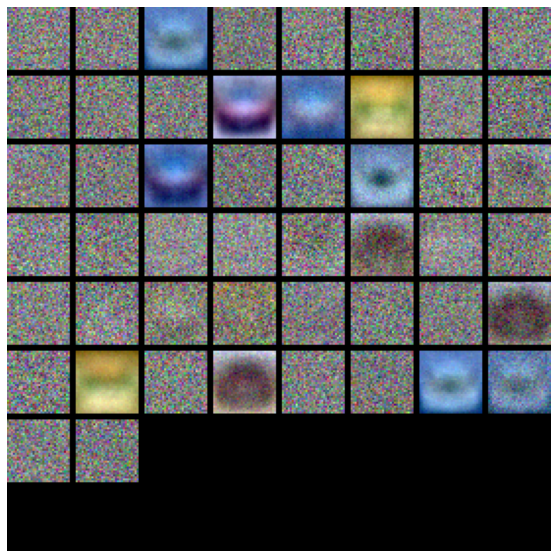

In [90]:
from vis_utils import visualize_grid

plt.rcParams['figure.figsize'] = [10, 10]

plt.imshow(visualize_grid(W_relu[0].reshape(32, 32, 3, -1).transpose(3, 0, 1, 2), padding=3).astype('uint8'))

plt.gca().axis('off')
plt.show()

<pre>You should see that if you re-train the network, the weight result visualization will be different.

---
# [Part 3] Hyperparameter Tuning

Now, let's build a two-layered Neural Network and train it using CIFAR-10 dataset

**What's wrong?**. 
* Looking at the visualizations above, we see that the loss is decreasing **more or less linearly**, which seems to suggest that the learning rate may be too low. 
* Moreover, there is **no gap between the training and validation** accuracy, suggesting that the model we used has low capacity, and that we should increase its size. 
* On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

<br>

**Tuning**. 
* Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice.
* Below, you should experiment with different values of the various hyperparameters, including **hidden layer size**, **learning rate**, and **regularization strength**. 
* You might also consider tuning the **learning rate decay**, but you should be able to get good performance using the default value.

<br>

**Approximate results**. 
* You should be aim to achieve a classification accuracy of greater than **48% on the validation set**. 
* Our best network gets over 52% on the validation set.

---
## 1 - Fine Tune the Network

#### <font color="red">**EXERCISE:**</font>
    * Use the validation set to tune hyperparameters (regularization strength and learning rate)
    * find the best learning rate and regularization strength using staged random search, (Coarse-to-Fine Search)
    * try to gradually decrease the random range to find the best learning rate and regularization strength
    * use only few epochs or iteration

In [91]:
import warnings
import datetime
warnings.filterwarnings('ignore')

results   = {}
best_val  = -1
best_reg  = 0
best_lr   = 0

best_W    = None
best_b    = None
max_epoch = 3
max_trial = 30

for trial in range(max_trial):
    
    reg  = 10**np.random.uniform(-2, 1)     # <---------- you can try and change this <----------
    lr   = 10**np.random.uniform(-2,-4)     # <---------- you can try and change this <----------    
    hidden_size = 200                       # <---------- you can try and change this <----------    
    
    W, b, H = train_two_layer_relu(X_train, y_train, X_val, y_val, hidden_size,
                                      epochs=max_epoch, batch_size=200, 
                                      lr=lr, lr_decay=0.9, 
                                      reg=reg, verbose=False) 
    val_acc = (predict_two_layer_relu(X_val, W, b) == y_val).mean() 
    if val_acc > best_val: 
        best_W = W 
        best_b = b 
        best_val = val_acc 
        best_lr  = lr 
        best_reg = reg 
    print( "%s,   val_acc: %1.4f,   lr: %1.15f,   reg: %1.15f,   trial: %s/%s" % 
          (str(datetime.datetime.now()), val_acc, lr, reg, trial, max_trial ) )
    
print ("best regularizer  : ", best_reg)
print ("best learning rate: ", best_lr)



2020-09-27 05:16:03.786814,   val_acc: 0.2035,   lr: 0.000109308002239,   reg: 0.724840239981296,   trial: 0/30
2020-09-27 05:16:28.084188,   val_acc: 0.2775,   lr: 0.000183390425845,   reg: 0.063898971781453,   trial: 1/30
2020-09-27 05:16:52.594423,   val_acc: 0.3616,   lr: 0.000438891604474,   reg: 0.935614031045532,   trial: 2/30
2020-09-27 05:17:17.411430,   val_acc: 0.4202,   lr: 0.002398991819756,   reg: 0.617680553321673,   trial: 3/30
2020-09-27 05:17:45.773150,   val_acc: 0.3255,   lr: 0.000262449562377,   reg: 0.050362936221445,   trial: 4/30
2020-09-27 05:18:09.911216,   val_acc: 0.4054,   lr: 0.000570523266854,   reg: 0.041328549332591,   trial: 5/30
2020-09-27 05:18:34.140509,   val_acc: 0.3719,   lr: 0.003373299965190,   reg: 0.165081946914769,   trial: 6/30
2020-09-27 05:18:58.113167,   val_acc: 0.1014,   lr: 0.005413699608102,   reg: 0.020384905871773,   trial: 7/30
2020-09-27 05:19:22.087091,   val_acc: 0.1014,   lr: 0.005391890017231,   reg: 0.178846676194602,   tria

#### <font color="red">**EXERCISE:**</font>
    * Try different range of hyperparameter
    * Try different strategy to find the hyperparameter
    * Try to finetune the other hyperparameter such as number of hidden neuron and lr_decay
    * Try other architectures such as changing the activation function

---
## 2 - Train the Network Fully

When you are done experimenting,

Train the network for longer epochs using the best **`learning rate`** and best **`regularization strength`**


In [92]:
print ("regularizer  : ", best_reg)
print ("learning rate: ", best_lr)

best_W, best_b, history = train_two_layer_relu(X_train, y_train, X_val, y_val,
                                               W = best_W, b = best_b,
                                               hidden_size=50, epochs=15, 
                                               lr = best_lr, reg = best_reg)

regularizer  :  0.022289996166485762
learning rate:  0.002181663235887333
iteration 100 (epoch 0 / 15 ): loss = 1.405961328038745
iteration 200 (epoch 0 / 15 ): loss = 1.6416802038224105
iteration 300 (epoch 1 / 15 ): loss = 1.571712064093231
iteration 400 (epoch 1 / 15 ): loss = 1.5033178481635388
iteration 500 (epoch 2 / 15 ): loss = 1.2726504719138605
iteration 600 (epoch 2 / 15 ): loss = 1.4095752358400695
iteration 700 (epoch 3 / 15 ): loss = 1.3067466078219188
iteration 800 (epoch 3 / 15 ): loss = 1.5013535710668142
iteration 900 (epoch 4 / 15 ): loss = 1.3200185012972725
iteration 1000 (epoch 4 / 15 ): loss = 1.4372253115024667
iteration 1100 (epoch 5 / 15 ): loss = 1.1594232827527824
iteration 1200 (epoch 5 / 15 ): loss = 1.3961109840232007
iteration 1300 (epoch 6 / 15 ): loss = 1.3240552758843007
iteration 1400 (epoch 6 / 15 ): loss = 1.2264528069671365
iteration 1500 (epoch 7 / 15 ): loss = 1.2133366811948267
iteration 1600 (epoch 7 / 15 ): loss = 1.2446910320641922
iteration

Visualize the loss

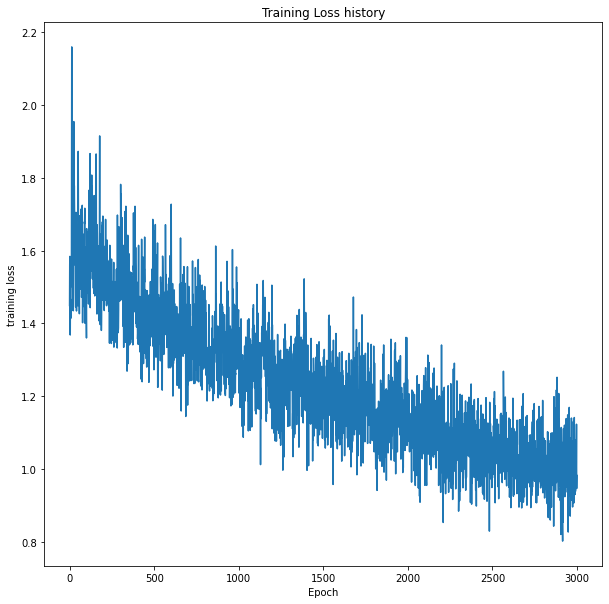

In [93]:
loss, train_acc, val_acc = history
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


Visualize the training and validation accuracy

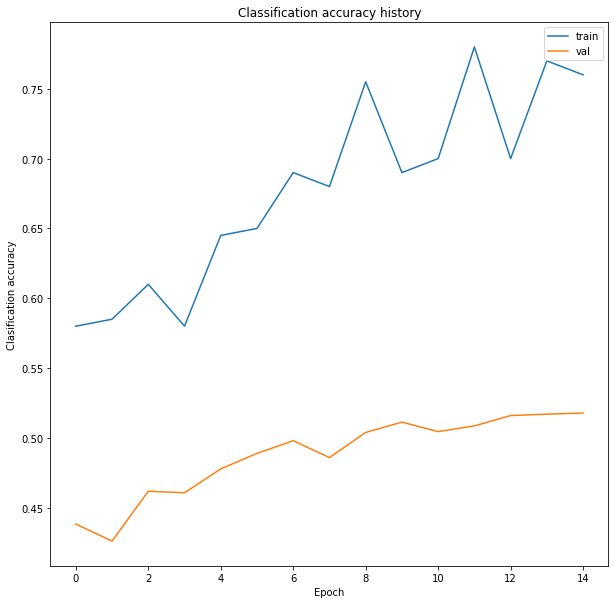

In [94]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

---
## 3 - Accuracy and Visualization
Calculate the Training Accuracy

In [95]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_two_layer_relu(X_train, best_W, best_b)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label  =',y_train[:15])
print('Predicted label =',y_pred[:15])

Training Accuracy = 69.2225 %
Training label  = [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9]
Predicted label = [6 9 9 6 1 1 2 7 8 1 4 9 7 9 9]


**EXPECTED OUTPUT**:

<pre>If you're careful, You should be able to get about <b>~60%</b> accuracy on training set 

In [96]:
y_pred = predict_two_layer_relu(X_val, best_W, best_b)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label =',y_val[:15])
print('Predicted label  =',y_pred[:15])

Validation Accuracy = 51.78 %
Validation label = [1 8 5 1 5 7 4 3 8 2 7 2 0 1 5]
Predicted label  = [9 2 2 1 7 7 4 5 8 4 5 3 8 4 5]


**EXPECTED OUTPUT**:

<pre>You should also be able to get about <b>~50%</b> accuracy on validation set</pre>

<br>

You can retrain further the weights by adding the pre-trained W and b to the arguments when calling training function

---


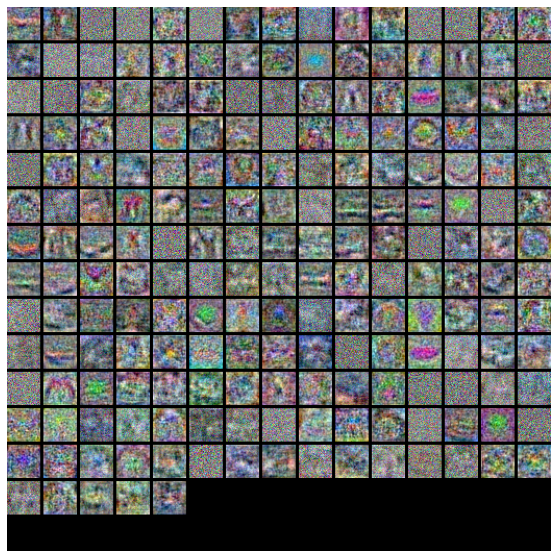

In [97]:
plt.imshow(visualize_grid(best_W[0].reshape(32, 32, 3, -1).transpose(3, 0, 1, 2), padding=3).astype('uint8'))

plt.gca().axis('off')
plt.show()

---
## 4 - Test the Trained Weights

Evaluate your final trained network on the test set; you should be able get **above 48%.**

In [98]:
y_pred = predict_two_layer_relu(X_test, best_W, best_b)

accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('Testing Accuracy =', accuracy*100,'%')
print('Test label       =',y_test[:15])
print('Predicted label  =',y_pred[:15])

Testing Accuracy = 51.870000000000005 %
Test label       = [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]
Predicted label  = [3 8 8 4 4 6 1 6 5 1 8 9 2 7 1]


**EXPECTED OUTPUT**:

<pre>If you're careful, You should be able to get about <b>~48%</b> accuracy on test set 

---
## 5 - Missclassified Images
An important way to gain intuition about how an algorithm works is to visualize the mistakes that it makes. 
 
 In this visualization, we show examples of images that are misclassified by our current system. 
 
 The first column  shows images that our system labeled as "plane" but whose true label is  something other than "plane".



    missclassified images



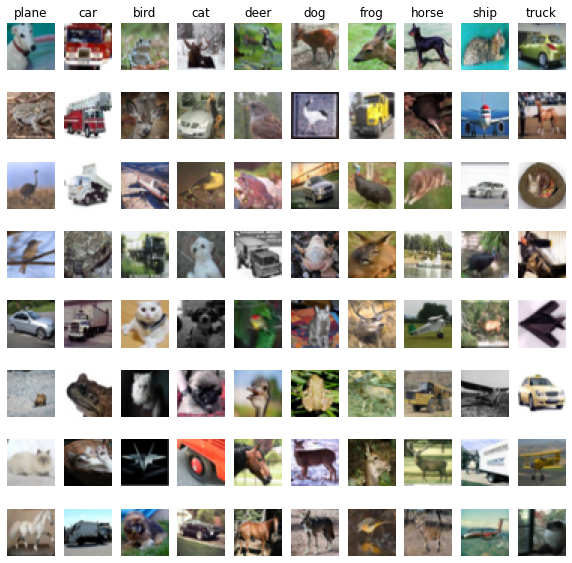

In [99]:
plt.rcParams['figure.figsize'] = [10, 10]

print('\n\n    missclassified images\n')
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test_ori[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()


---
# [Part 4] Two-Layer NN on Feature Space

Similar with the previous exercise, in this exercise we will show that we can improve our classification performance by training two-layer classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [100]:
from __future__ import print_function

from scipy.ndimage import uniform_filter

## 1 - Feature Extraction Functions


In [101]:
def extract_features(imgs, feature_fns, verbose=False):
    num_images = imgs.shape[0]
    if num_images == 0:
        return np.array([])

    feature_dims = []
    first_image_features = []
    for feature_fn in feature_fns:
        feats = feature_fn(imgs[0].squeeze())
        assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
        feature_dims.append(feats.size)
        first_image_features.append(feats)

    total_feature_dim = sum(feature_dims)
    imgs_features = np.zeros((num_images, total_feature_dim))
    imgs_features[0] = np.hstack(first_image_features).T

    for i in range(1, num_images):
        idx = 0
        for feature_fn, feature_dim in zip(feature_fns, feature_dims):
            next_idx = idx + feature_dim
            imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
            idx = next_idx
        if verbose and i % 1000 == 0:
            print('Done extracting features for %d / %d images' % (i, num_images))

    return imgs_features

In [102]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.144])

In [103]:
def hog_feature(im):

    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    sx, sy = image.shape  
    orientations = 9      
    cx, cy = (8, 8)       

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1)
    gy[:-1, :] = np.diff(image, n=1, axis=0)
    grad_mag = np.sqrt(gx ** 2 + gy ** 2) 
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90  

    n_cellsx = int(np.floor(sx / cx)) 
    n_cellsy = int(np.floor(sy / cy))
    
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
    for i in range(orientations):        
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:, :, i] = uniform_filter(temp_mag, size=(cx, cy))[int(cx / 2)::cx, int(cy / 2)::cy].T

    return orientation_histogram.ravel()



In [104]:
def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
    ndim = im.ndim
    bins = np.linspace(xmin, xmax, nbin + 1)
    hsv = matplotlib.colors.rgb_to_hsv(im / xmax) * xmax
    imhist, bin_edges = np.histogram(hsv[:, :, 0], bins=bins, density=normalized)
    imhist = imhist * np.diff(bin_edges)

    return imhist

## 2 - Reload the CIFAR-10 dataset

In [105]:
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

mask = list(range(40000, 50000))
X_val = X_train[mask]
y_val = y_train[mask]
mask = list(range(40000))
X_train = X_train[mask]
y_train = y_train[mask]

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'forse', 'ship', 'truck']

Clear previously loaded data.


## 3 - Extract Features

In [106]:
num_color_bins = 20 # Number of bins in the color histogram
feature_fns    = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_feats  = extract_features(X_train, feature_fns, verbose=True)
X_val_feats    = extract_features(X_val, feature_fns)
X_test_feats   = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats   = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats  = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 40000 images
Done extracting features for 2000 / 40000 images
Done extracting features for 3000 / 40000 images
Done extracting features for 4000 / 40000 images
Done extracting features for 5000 / 40000 images
Done extracting features for 6000 / 40000 images
Done extracting features for 7000 / 40000 images
Done extracting features for 8000 / 40000 images
Done extracting features for 9000 / 40000 images
Done extracting features for 10000 / 40000 images
Done extracting features for 11000 / 40000 images
Done extracting features for 12000 / 40000 images
Done extracting features for 13000 / 40000 images
Done extracting features for 14000 / 40000 images
Done extracting features for 15000 / 40000 images
Done extracting features for 16000 / 40000 images
Done extracting features for 17000 / 40000 images
Done extracting features for 18000 / 40000 images
Done extracting features for 19000 / 40000 images
Done extracting features for 20000 / 40000 images
Done extr

In [107]:
y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

print('X_train_feats.shape =', X_train_feats.shape)

print('y_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

X_train_feats.shape = (40000, 165)
y_train.shape = (40000,)
y_val.shape   = (10000,)
y_test.shape  = (10000,)


## 4 - Train a Two-Layer Neural Network

Again, fine tune the network, and find the best hyperparameter (learning rate, regularizations, bins, hidden neuron, etc)

Then train the network once again using feature space CIFAR10 dataset

In [108]:
W, b, H = train_two_layer_relu(X_train_feats, y_train, X_val_feats, y_val,
                               hidden_size=100, epochs=10,
                               lr = 0.9, reg = 0.0)

iteration 100 (epoch 0 / 10 ): loss = 2.308887254063053
iteration 200 (epoch 0 / 10 ): loss = 2.304468338184032
iteration 300 (epoch 1 / 10 ): loss = 2.303506294156874
iteration 400 (epoch 1 / 10 ): loss = 2.303047950982552
iteration 500 (epoch 2 / 10 ): loss = 2.3024852190843723
iteration 600 (epoch 2 / 10 ): loss = 2.3034113886821985
iteration 700 (epoch 3 / 10 ): loss = 2.3059361718571556
iteration 800 (epoch 3 / 10 ): loss = 2.312374799156895
iteration 900 (epoch 4 / 10 ): loss = 2.2999392977460906
iteration 1000 (epoch 4 / 10 ): loss = 2.3027658209105657
iteration 1100 (epoch 5 / 10 ): loss = 2.302243240823105
iteration 1200 (epoch 5 / 10 ): loss = 2.3018787915499956
iteration 1300 (epoch 6 / 10 ): loss = 2.301465574066381
iteration 1400 (epoch 6 / 10 ): loss = 2.3015044735295334
iteration 1500 (epoch 7 / 10 ): loss = 2.309029064897111
iteration 1600 (epoch 7 / 10 ): loss = 2.3044779485258085
iteration 1700 (epoch 8 / 10 ): loss = 2.303217032827403
iteration 1800 (epoch 8 / 10 ): 

This approach should outperform all previous approaches: you should easily be able to achieve **over 55%** classification accuracy on the test set; 

our best model achieves **about 60%** classification accuracy.

In [109]:
y_pred = predict_two_layer_relu(X_val_feats, W, b)

accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)

print('Validation Accuracy =', accuracy*100,'%')
print('Test label          =',y_val[:15])
print('Predicted label     =',y_pred[:15])

Validation Accuracy = 10.14 %
Test label          = [1 8 5 1 5 7 4 3 8 2 7 2 0 1 5]
Predicted label     = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [110]:
y_pred = predict_two_layer_relu(X_test_feats, W, b)

accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('Testing Accuracy =', accuracy*100,'%')
print('Test label       =',y_test[:15])
print('Predicted label  =',y_pred[:15])

Testing Accuracy = 10.0 %
Test label       = [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]
Predicted label  = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


---
## 5 - Missclassified Images
An important way to gain intuition about how an algorithm works is to visualize the mistakes that it makes. 
 
 In this visualization, we show examples of images that are misclassified by our current system. 
 
 The first column  shows images that our system labeled as "plane" but whose true label is  something other than "plane".



    missclassified images

________ 9000
________ 0


ValueError: ignored

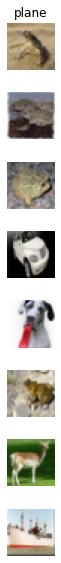

In [116]:
plt.rcParams['figure.figsize'] = [10, 10]

print('\n\n    missclassified images\n')
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False )
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test_ori[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()


---

# Congratulation, You've Completed Exercise 3

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)